<a href="https://colab.research.google.com/github/paolofesta/prove/blob/master/TESI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tweepy
import matplotlib.pyplot as plt
import seaborn as sns
from  matplotlib.ticker import PercentFormatter



In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)
stopwords.update(['il','la','di','con','su','per','tra','ci','sempre','fra','una','nel','dopo','alla','della','sono','dalla','al','un','non','più','dell','ma','dei','gli','lo','sul','da','ha','si','nei','le','delle','ai','solo','ad','siete','abbiamo','ora','oggi','che','maggio','nella','ed','come','del','questo','fa','anche','anni','alle','degli','dare','xix','tutto','poteva','notizia','se','serve','nuovo','questa','altre']) #adding our own stopwords

In [ ]:
# VARIABILI CREATE CON LE CREDENZIALI PER ACCEDERE ALLE API
ACCESS_TOKEN = '1500753981525659655-2OYENj2RBJS753zwIZ9a9zQukiSHY5'
ACCESS_SECRET = 'M1naDc08ZQuWYX7yZV4hRZ8IwH0J5uiraPXNzTe6Py2TL'
CONSUMER_KEY = 'yOKa2wpMnubBCq6pV3XLD8lRL'
CONSUMER_SECRET = 'pDyuUu4ssKWS4PHF4wN2lZ7RjdYQe1yLjBbK745o3vdOoxgtUN'

In [ ]:
# SETUP ACCESSO API
def connect_to_twitter_OAuth():
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

    api = tweepy.API(auth, wait_on_rate_limit=True ,wait_on_rate_limit_notify=True)
    return api
    
api = connect_to_twitter_OAuth()

In [ ]:
def limit_handled(cursor):
  while True:
    try:
      yield cursor.next()
    except StopIteration:
      return
    except tweepy.RateLimitError:
        time.sleep(15*60)

In [ ]:
pp1=limit_handled(tweepy.Cursor(api.search,q= '@CislNazionale',tweet_mode='extended').items(5000)) 
pp1

In [ ]:

def extract_tweet_attributes(tweet_object):
    # create empty list
    tweet_list =[]
    # loop through tweet objects
    for tweet in tweet_object:
        tweet_id = tweet.id # unique integer identifier for tweet
        language= tweet.lang 
        name= tweet.user.name     
        location= tweet.user.location
        
        follower_count= tweet.user.followers_count
        verified= tweet.user.verified
        text = tweet.full_text # utf-8 text of tweet
        favorite_count = tweet.favorite_count
        retweet_count = tweet.retweet_count
        created_at = tweet.created_at # utc time tweet created
        source = tweet.source # utility used to post tweet
       
       
        # append attributes to list
        tweet_list.append({'tweet_id':tweet_id,
                           'language':language,
                          'text':text,
                           'name':name,
                           'location':location,
                           
                          'follower_count':follower_count,
                           'verified': verified,
                          'favorite_count':favorite_count,
                          'retweet_count':retweet_count,
                          'created_at':created_at, 
                          'source':source, 
                          })

    # create dataframe   
    df1 = pd.DataFrame(tweet_list, columns=['tweet_id',
                                           'text',
                                           'language',
                                           'name',
                                          
                                           'follower_count',
                                           'verified',
                                           'location',    
                                           'favorite_count',
                                           'retweet_count',
                                           'created_at',
                                           'source',
                                           ])
    return df1


df1 = extract_tweet_attributes(pp1)


In [ ]:
df1['name']=df1.loc[df1['name']!='CISL Nazionale']

In [ ]:
df1['sigla']='CISL'

In [ ]:
df1.to_csv(r'cisl_data',index=False)

In [ ]:
#processo ripetuto anche per cgil e uil per ottenere:
cisl_data=pd.read_csv(r'/content/cisl_data')
cgil_data=pd.read_csv(r'/content/cgil_data')
uil_data=pd.read_csv(r'/content/uil_data')


In [ ]:
#data=pd.concat(cisl_data,cgil_data,uil_data)

In [ ]:
#data=pd.read_csv(r'/content/data')



**AGGIUNTA DEI TWEET RACCOLTI IL 23/7**

In [27]:
d1=pd.read_csv(r'/content/data1°giro')
d2=pd.read_csv(r'/content/data2(23-7)')
data=pd.concat([d1,d2], ignore_index=True)



In [28]:
data.to_csv(r'data',index=False)

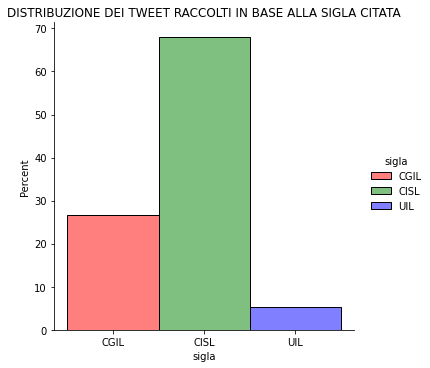

In [ ]:
sns.displot(data,x="sigla",stat="percent",hue="sigla",palette=['r','g','b'])
plt.title('DISTRIBUZIONE DEI TWEET RACCOLTI IN BASE ALLA SIGLA CITATA')
print()


In [2]:
import re
import gensim
from nltk.stem import WordNetLemmatizer

punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'


In [3]:
def remove_links(tweet):
    """Takes a string and removes web links from it"""
    tweet = re.sub(r'http\S+', '', tweet)   # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet)  # remove bitly links
    tweet = tweet.strip('[link]')   # remove [links]
    tweet = re.sub(r'pic.twitter\S+','', tweet)
    return tweet

In [4]:
def remove_users(tweet):
    """Takes a string and removes retweet and @user information"""
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove re-tweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove tweeted at
    return tweet


In [5]:
def remove_hashtags(tweet):
    """Takes a string and removes any hash tags"""
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove hash tags
    return tweet

In [6]:
def remove_av(tweet):
    """Takes a string and removes AUDIO/VIDEO tags or labels"""
    tweet = re.sub('VIDEO:', '', tweet)  # remove 'VIDEO:' from start of tweet
    tweet = re.sub('AUDIO:', '', tweet)  # remove 'AUDIO:' from start of tweet
    return tweet

In [7]:
regex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
def remove_em(tweet):
    tweet = re.sub(regex_pattern,'',tweet) #replaces pattern with ''
    return tweet


In [8]:
def basic_clean(tweet):
    """Main master function to clean tweets only without tokenization or removal of stopwords"""
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_av(tweet)
    tweet = remove_em(tweet)
    tweet = tweet.lower()  # lower case
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  # strip punctuation
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet)  # remove numbers
    tweet = re.sub('📝 …', '', tweet)
    return tweet

In [ ]:
df1=pd.read_csv('/content/data (1)',usecols=['text']) 
df1['tweet']=df1['text']
df2=df1.drop('text',axis=1)
df2

In [11]:
def clean_tweets(df):
    """Main function to read in and return cleaned and preprocessed dataframe.
    This can be used in Jupyter notebooks by importing this module and calling the tokenize_tweets() function
    Args:
        df = data frame object to apply cleaning to
    Returns:
        pandas data frame with cleaned tokens
    """

    df['cleaned'] = df.tweet.apply(basic_clean)
    num_tweets = len(df)
    print('Complete. Number of Tweets that have been cleaned and tokenized : {}'.format(num_tweets))
    return df

In [12]:
df3=clean_tweets(df2)
df3 #non faccio tokenizzazione e lemmatizzazione perchè FEEL-IT funziona con le frasi di senso compiuto

Complete. Number of Tweets that have been cleaned and tokenized : 13365


,tweet,cleaned
0,RT @kastatrof: Imaginez.. à qq heures de route...,imaginez à qq heures de route un univers para...
1,@cgilnazionale Sembra una supercazzola... prem...,sembra una supercazzola prematurata con scapp...
2,RT @kastatrof: Imaginez.. à qq heures de route...,imaginez à qq heures de route un univers para...
3,🟥SOLO LA PACE\n@cgilnazionale partecipa all'ac...,🟥solo la pace partecipa all accoglienza di or...
4,@fpcgil_internaz @fbunational @FpCgilVVF @EPSU...,
...,...,...
13360,@paolo_r_2012 @INL_gov @AndreaOrlandosp @MinLa...,terribile
13361,RT @UILofficial: La crisi di Governo è un grav...,la crisi di governo è un grave danno per lavo...
13362,"RT @emalombardini: #crisidigoverno , appello a...",appello alla responsabilità da oltre sindaci...
13363,RT @UILofficial: La crisi di Governo è un grav...,la crisi di governo è un grave danno per lavo...


## Citation

Please use the following bibtex entry if you use this model in your project:

```
@inproceedings{bianchi2021feel,
    title = {{"FEEL-IT: Emotion and Sentiment Classification for the Italian Language"}},
    author = "Bianchi, Federico and Nozza, Debora and Hovy, Dirk",
    booktitle = "Proceedings of the 11th Workshop on Computational Approaches to Subjectivity, Sentiment and Social Media Analysis",
    year = "2021",
    publisher = "Association for Computational Linguistics",
}
```

In [13]:
pip install feel-it

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.0 MB/s 
     |████████████████████████████████| 880 kB 51.0 MB/s 
     |████████████████████████████████| 3.3 MB 42.7 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=5a4f9699da797e6eacfe1670d846af0dd2ef96d3fc77fbca9ae3608194016137
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [14]:
from feel_it import EmotionClassifier
emotion_classifier = EmotionClassifier()

Downloading:   0%|          | 0.00/899 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/794k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.68M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/299 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/414 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/443M [00:00<?, ?B/s]

In [15]:
dfcleaned=df3.drop('tweet',axis=1).astype('str')


In [16]:
cleanedstring=pd.Series(dfcleaned['cleaned'].astype('string'))
cleanedstring.dtype

string[python]

In [17]:
def stringToList(string):
  listRes = list(string.split(""))
  return listRes

In [ ]:
cleanedlist=cleanedstring.tolist()
cleanedlist

In [19]:
from feel_it import EmotionClassifier
emotion_classifier = EmotionClassifier()
from feel_it import SentimentClassifier
sentiment_classifier = SentimentClassifier()

Downloading:   0%|          | 0.00/847 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/794k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.68M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/299 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/414 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/443M [00:00<?, ?B/s]

In [25]:
sentimenti=sentiment_classifier.predict(cleanedlist)

In [20]:
emozioni=emotion_classifier.predict(cleanedlist)

In [29]:
data['sentiment']=sentimenti
data['emotion']=emozioni
data['cleaned_text']=cleanedlist

In [ ]:
data=data.loc[data['language']=='it'].drop('text',axis=1)
data

In [ ]:
datasent=data
datasent.to_csv(r'datasent',index=False)

In [ ]:
datasentcisl=datasent.loc[datasent['sigla']=='CISL']
datasentcisl.to_csv(r'datasentcisl',index=False)

In [ ]:
datasentcgil=datasent.loc[datasent['sigla']=='CGIL']
datasentcgil.to_csv(r'datasentcgil',index=False)

In [ ]:
datasentuil=datasent.loc[datasent['sigla']=='UIL']
datasentuil.to_csv(r'datasentuil',index=False)

In [ ]:
datasent=pd.read_csv('/content/datasent')

In [32]:
dataword=datasent


In [33]:
dneg=dataword.loc[dataword['sentiment']=='negative']
dpos=dataword.loc[dataword['sentiment']=='positive']



In [34]:
words=pd.Series(dneg['cleaned_text']).astype('string').str.cat(sep=' ')

In [41]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)
stopwords.update(['il','la','di','con','su','per','tra','fra','una','nel','dopo','alla','della','sono','dalla','al','un','non','più','dell','ma','dei','gli','lo','sul','da','ha','si','nei','le','delle','ai','solo','ad','siete','abbiamo','ora','oggi','che','maggio','nella','ed','come','del','questo','fa','anche','anni','alle','degli','cui','dare','uil','cgil','cisl','ci','xix','tutto','poteva','notizia','se','serve','nuovo','questa','altre']) #adding our own stopwords

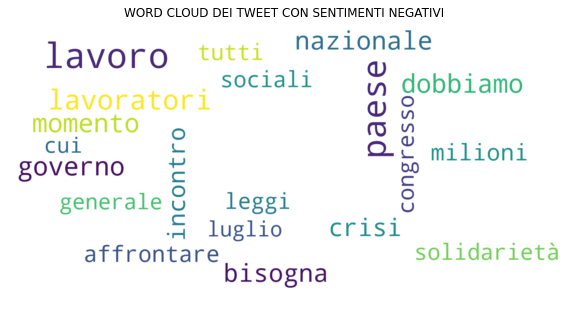

In [40]:
wordcloud = WordCloud(width=1600, stopwords=stopwords,height=800,max_font_size=100,max_words=20,collocations=False, background_color='white').generate(words)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('WORD CLOUD DEI TWEET CON SENTIMENTI NEGATIVI ')
print()   

In [42]:
words1=pd.Series(dpos['cleaned_text']).astype('string').str.cat(sep=' ')

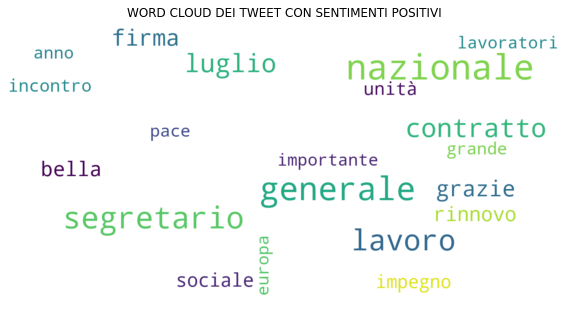

In [43]:
wordcloud = WordCloud(width=1600, stopwords=stopwords,height=800,max_font_size=100,max_words=20,collocations=False, background_color='white').generate(words1)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('WORD CLOUD DEI TWEET CON SENTIMENTI POSITIVI ')   
print()

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from  matplotlib.ticker import PercentFormatter


In [ ]:
#datasent.count()#=12560
#datasent.loc[datasent['sentiment']=='negative'].count()#=8880
#datasent.loc[datasent['sentiment']=='positive'].count()#=3680

In [56]:
c={'percent':[(8880/12560)*100,(3680/12560)*100],'sentiment':['negative','positive']}
df=pd.DataFrame(c)
df['percent']=df['percent'].astype('int')

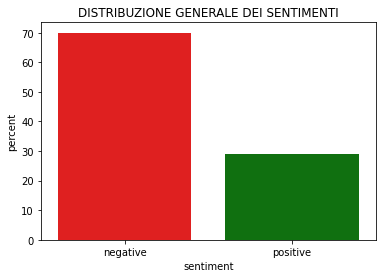

In [57]:

sns.barplot(data=df,x='sentiment',y='percent',palette=['r','g']).set_title('DISTRIBUZIONE GENERALE DEI SENTIMENTI') 
print()

In [ ]:
#datasent.loc[(datasent['sigla']=='CISL')].count()#=8810
#datasent.loc[(datasent['sigla']=='CISL') & (datasent['sentiment']=='negative')].count()#=5773
#datasent.loc[(datasent['sigla']=='CISL') & (datasent['sentiment']=='positive')].count()#=3037
#datasent.loc[(datasent['sigla']=='CGIL')].count()#=3104
#datasent.loc[(datasent['sigla']=='CGIL') & (datasent['sentiment']=='negative')].count()#=2604
#datasent.loc[(datasent['sigla']=='CGIL') & (datasent['sentiment']=='positive')].count()#=500
#datasent.loc[(datasent['sigla']=='UIL')].count()#=646
#datasent.loc[(datasent['sigla']=='UIL') & (datasent['sentiment']=='negative')].count()#=503
#datasent.loc[(datasent['sigla']=='UIL') & (datasent['sentiment']=='positive')].count()#=143

In [67]:
d={'percent':[(5773/8810)*100,(3037/8810)*100,(2604/3104)*100,(500/3104)*100,(503/646)*100,(143/646)*100],'sentiment':['negative','positive','negative','positive','negative','positive'],'sigla':['CISL','CISL','CGIL','CGIL','UIL','UIL']}
df1=pd.DataFrame(data=d)
df1['percent']=df1['percent'].astype('int')



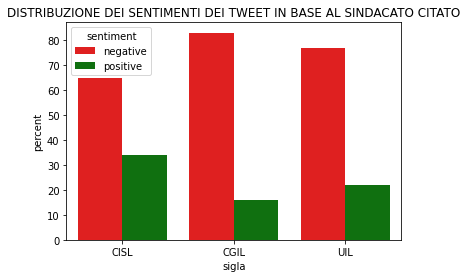

In [69]:
sns.barplot(data=df1,x='sigla',y='percent',hue='sentiment',palette=['r','g']).set_title('DISTRIBUZIONE DEI SENTIMENTI DEI TWEET IN BASE AL SINDACATO CITATO') 
print()

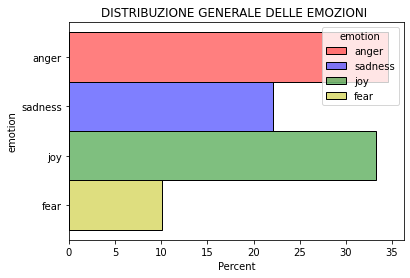

In [70]:
sns.histplot(datasent,y='emotion',stat='percent',hue='emotion',palette=['r','b','g','y']).set_title('DISTRIBUZIONE GENERALE DELLE EMOZIONI ') 
print()

QUESTE SONO LE OPINIONI GENERALI, MA CHI LE ESPRIME?\
come cambiano tra sezioni regionali/provinciali dei sindacati e altri utenti?\
quanti follower ha chi scrive? quale distribuzione di utenti in base al numero di follower? come cambiano le opinioni tra utenti in base al numero di follower?\
come cambiano le opinioni in base a età,posizione politica,posizione nel mdl, zona geografica mediante l'osservazione 'manuale' di un campione di utenti?

**ARTICOLAZIONI DEI SINDACATI E UTENTI AUTONOMI:QUALI DIFFERENZE?**

In [71]:
def low_name(tweet):
  
    tweet = tweet.lower()  # lower case
    
    return tweet

In [72]:
def low_df(df):
   

    df['lower'] = df.tweet.apply(low_name)
    num_tweets = len(df)
    
    return df

In [73]:
datan=pd.read_csv('/content/datasent',usecols=['name']) 
datan['tweet']=datan['name']
datanext=datan.drop('name',axis=1)
datanext

,tweet
0,Patsy 🇮🇹
1,FLC CGIL Roma Lazio
2,Piero Passalacqua
3,Daniele Calosi
4,Vilma
...,...
12555,mauro evangelista
12556,Paolo Roma
12557,Uiltec Calabria
12558,Loris Cavalletti


In [74]:
datalow=low_df(datanext).drop('tweet',axis=1)
datalow

,lower
0,patsy 🇮🇹
1,flc cgil roma lazio
2,piero passalacqua
3,daniele calosi
4,vilma
...,...
12555,mauro evangelista
12556,paolo roma
12557,uiltec calabria
12558,loris cavalletti


In [75]:
data_low_names=pd.read_csv('/content/datasent').drop('name',axis=1)
data_low_names['low_name']=datalow
data_low_names

,Unnamed: 0,tweet_id,language,follower_count,verified,location,favorite_count,retweet_count,created_at,source,sigla,sentiment,emotion,cleaned_text,low_name
0,1.0,1524824670125625345,it,36,False,NaN,1,0,2022-05-12 18:51:45,Twitter for Android,CGIL,negative,anger,sembra una supercazzola prematurata con scapp...,patsy 🇮🇹
1,3.0,1524804096439492612,it,1238,False,"Roma, Via Buonarroti 12",0,0,2022-05-12 17:30:00,Twitter Web App,CGIL,negative,sadness,🟥solo la pace partecipa all accoglienza di or...,flc cgil roma lazio
2,5.0,1524798008390475776,it,3,False,NaN,0,14,2022-05-12 17:05:49,Twitter for Android,CGIL,positive,joy,al via il da oggi fino al maggio a matera il...,piero passalacqua
3,7.0,1524795129533538311,it,1147,False,NaN,0,30,2022-05-12 16:54:22,Twitter for iPhone,CGIL,positive,joy,“il ripristino della clausola sociale negli è...,daniele calosi
4,8.0,1524793135800504321,it,604,False,Torino,0,8,2022-05-12 16:46:27,Twitter for Android,CGIL,positive,joy,ll ripristino della negli è un grande risulta...,vilma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12555,NaN,1549307228678651905,it,1109,False,Lanuvio esprimo idee personali,0,16,2022-07-19 08:16:42,Twitter for iPhone,UIL,negative,sadness,la crisi di governo è un grave danno per lavo...,mauro evangelista
12556,NaN,1549300671052234752,it,34131,False,"Lazio, Italia, UE",2,1,2022-07-19 07:50:39,Twitter for iPhone,UIL,positive,joy,vero sandra speriamo che entro dicembre sara...,paolo roma
12557,NaN,1549296792193441792,it,97,False,"Lamezia Terme, Calabria",0,16,2022-07-19 07:35:14,Twitter for iPhone,UIL,negative,sadness,la crisi di governo è un grave danno per lavo...,uiltec calabria
12558,NaN,1549268625386766344,it,914,False,NaN,0,3,2022-07-19 05:43:18,Twitter for iPhone,UIL,negative,anger,appello alla responsabilità da oltre sindaci...,loris cavalletti


In [76]:
datasent_associati=data_low_names.loc[(data_low_names['low_name'].str.contains('uil'))|(data_low_names['low_name'].str.contains('cisl'))|(data_low_names['low_name'].str.contains('cgil'))]
datasent_associati['articolazione']='SI'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [77]:
datasent_nonassociati=data_low_names[~((data_low_names['low_name'].str.contains('uil'))|(data_low_names['low_name'].str.contains('cisl'))|(data_low_names['low_name'].str.contains('cgil')))]
datasent_nonassociati['articolazione']='NO'


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [78]:
data=pd.concat([datasent_associati,datasent_nonassociati])

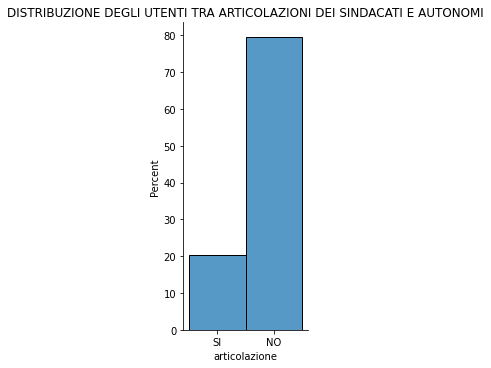

In [79]:
sns.displot(data,x='articolazione',kind='hist',aspect=.5,stat="percent")
plt.title("DISTRIBUZIONE DEGLI UTENTI TRA ARTICOLAZIONI DEI SINDACATI E AUTONOMI")
plt.ylim()
print()

In [80]:
wordsa=pd.Series(datasent_associati['cleaned_text']).astype('string').str.cat(sep=' ')

In [85]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)
stopwords.update(['il','la','di','con','su','per','luglio','tra','fra','una','nel','dopo','alla','della','sono','dalla','al','un','non','più','dell','ma','dei','gli','lo','sul','da','ha','si','nei','le','delle','ai','solo','ad','siete','abbiamo','ora','oggi','che','maggio','nella','ed','come','del','questo','fa','anche','anni','alle','degli','dare','xix','cisl','tutto','poteva','notizia','se','serve','nuovo','questa','altre']) #adding our own stopwords

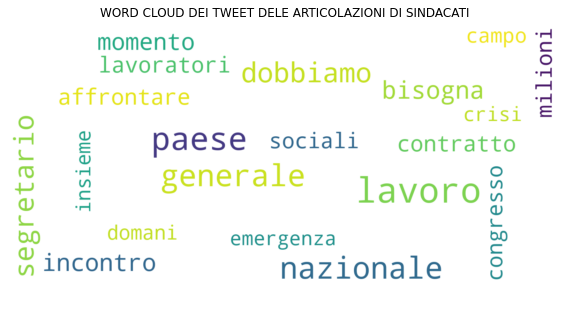

In [86]:
wordcloud = WordCloud(width=1600, stopwords=stopwords,height=800,max_font_size=100,max_words=20,collocations=False, background_color='white').generate(wordsa)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('WORD CLOUD DEI TWEET DELE ARTICOLAZIONI DI SINDACATI ')   
print()


In [87]:
wordsb=pd.Series(datasent_nonassociati['cleaned_text']).astype('string').str.cat(sep=' ')

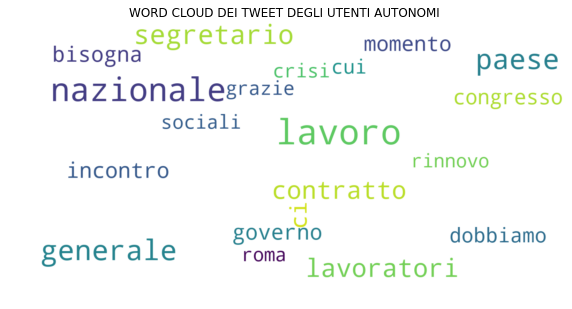

In [88]:

wordcloud = WordCloud(width=1600, stopwords=stopwords,height=800,max_font_size=100,max_words=20,collocations=False, background_color='white').generate(wordsb)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.title('WORD CLOUD DEI TWEET DEGLI UTENTI AUTONOMI ')   
print()

In [ ]:
#data.loc[(data['articolazione']=='SI')].count()#=2565
#data.loc[(data['articolazione']=='SI') & (data['sentiment']=='negative')].count()#=1689
#data.loc[(data['articolazione']=='SI') & (data['sentiment']=='positive')].count()#=876
#data.loc[(data['articolazione']=='NO')].count()#=9995
#data.loc[(data['articolazione']=='NO') & (data['sentiment']=='negative')].count()#=7191
#data.loc[(data['articolazione']=='NO') & (data['sentiment']=='positive')].count()#=2804


In [96]:
c={'percent':[(1689/2565)*100,(876/2565)*100,(7191/9995)*100,(2804/9995)*100],'sentiment':['negative','positive','negative','positive'],'articolazione':['SI','SI','NO','NO']}
df=pd.DataFrame(data=c)
df['percent']=df['percent'].astype('int')



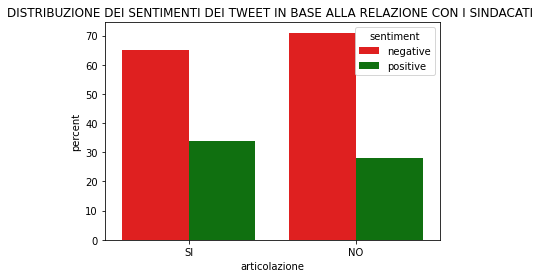

In [97]:
sns.barplot(data=df,x='articolazione',y='percent',hue='sentiment',palette=['r','g']).set_title('DISTRIBUZIONE DEI SENTIMENTI DEI TWEET IN BASE ALLA RELAZIONE CON I SINDACATI ') 
print()

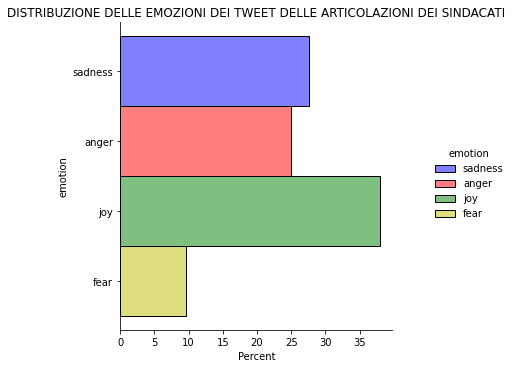

In [98]:
sns.displot(datasent_associati,y='emotion',stat='percent',hue='emotion',palette=['b','r','g','y'])
plt.title('DISTRIBUZIONE DELLE EMOZIONI DEI TWEET DELLE ARTICOLAZIONI DEI SINDACATI')
print() 

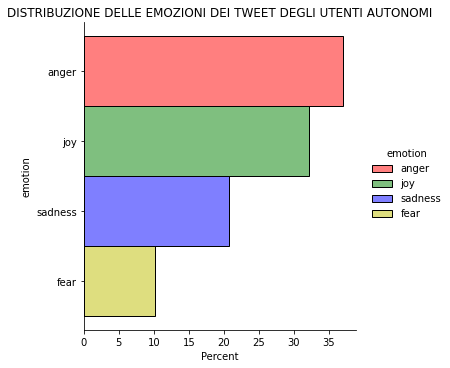

In [99]:
sns.displot(datasent_nonassociati,y='emotion',stat='percent',hue='emotion',palette=['r','g','b','y'])
plt.title('DISTRIBUZIONE DELLE EMOZIONI DEI TWEET DEGLI UTENTI AUTONOMI') 
print()

In [ ]:
#data.loc[(data['articolazione']=='SI')].count()#=2565
#data.loc[(data['articolazione']=='SI') & (data['emotion']=='sadness')].count()#=708
#data.loc[(data['articolazione']=='SI') & (data['emotion']=='fear')].count()#=246
#data.loc[(data['articolazione']=='SI') & (data['emotion']=='anger')].count()#=639
#data.loc[(data['articolazione']=='SI') & (data['emotion']=='joy')].count()#=972
#data.loc[(data['articolazione']=='NO')].count()#=9995
#data.loc[(data['articolazione']=='NO') & (data['emotion']=='sadness')].count()#=2067
#data.loc[(data['articolazione']=='NO') & (data['emotion']=='fear')].count()#=1018
#data.loc[(data['articolazione']=='NO') & (data['emotion']=='anger')].count()#=3701
#data.loc[(data['articolazione']=='NO') & (data['emotion']=='joy')].count()#=3209


In [ ]:
z={'percent':[(708/2565)*100,(246/2565)*100,(639/2565)*100,(972/2565)*100,(2067/9995)*100,(1018/9995)*100,(3701/9995)*100,(3209/9995)*100],'emotion':['sadness','fear','anger','joy','sadness','fear','anger','joy'],'articolazione':['SI','SI','SI','SI','NO','NO','NO','NO']}
df1=pd.DataFrame(data=z)
df1



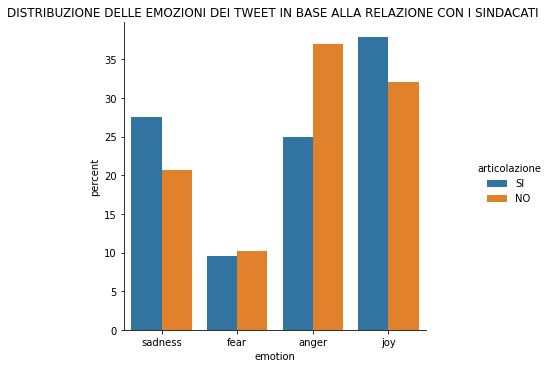

In [112]:
sns.catplot(data=df1,x='emotion',y='percent',hue='articolazione',kind='bar', dodge=True)
plt.title('DISTRIBUZIONE DELLE EMOZIONI DEI TWEET IN BASE ALLA RELAZIONE CON I SINDACATI ') 
print()



**NUMERO DI FOLLOWER E OPINIONI: QUALE CORRELAZIONE?**

In [ ]:
datasent=pd.read_csv('/content/datasent') #mi sono fermato qui ad aggiornare

In [ ]:
quartili=pd.DataFrame(datasent['follower_count'].quantile(np.linspace(0.0,1.0,num=5)))
quartili

,follower_count
0.00,0.0
0.25,156.0
0.50,462.0
0.75,1384.0
1.00,381665.0


In [ ]:
data=datasent
d1=data.loc[data['follower_count']<=156]
d1['followers']='(Q1) 0-156'
d2=data.loc[(data['follower_count']>156)&(data['follower_count']<=462)]
d2['followers']='(Q2) 157-426'
d3=data.loc[(data['follower_count']>462)&(data['follower_count']<=1384)]
d3['followers']='(Q3) 427-1384'
d4=data.loc[(data['follower_count']>1384)&(data['follower_count']<=381665)]
d4['followers']='(Q4) 1385-381665'
df=pd.concat([d1,d2,d3,d4])
df


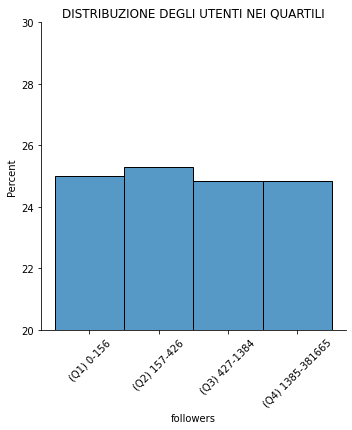

In [ ]:
sns.displot(df,x='followers',kind='hist',aspect=1,stat="percent")
plt.title("DISTRIBUZIONE DEGLI UTENTI NEI QUARTILI")
plt.ylim(20,30)
plt.xticks(rotation=45)
print()

In [ ]:
#df.loc[(df['followers']=='(Q1) 0-156')].count()#=1612
#df.loc[(df['followers']=='(Q1) 0-156') & (df['sentiment']=='negative')].count()#=1056
#df.loc[(df['followers']=='(Q1) 0-156') & (df['sentiment']=='positive')].count()#=556
#df.loc[(df['followers']=='(Q2) 157-426')].count()#=1629
#df.loc[(df['followers']=='(Q2) 157-426') & (df['sentiment']=='negative')].count()#=984
#df.loc[(df['followers']=='(Q2) 157-426') & (df['sentiment']=='positive')].count()#=645
#df.loc[(df['followers']=='(Q3) 427-1384')].count()#=1601
#df.loc[(df['followers']=='(Q3) 427-1384') & (df['sentiment']=='negative')].count()#=974
#df.loc[(df['followers']=='(Q3) 427-1384') & (df['sentiment']=='positive')].count()#=627
#df.loc[(df['followers']=='(Q4) 1385-381665')].count()#=1601
#df.loc[(df['followers']=='(Q4) 1385-381665') & (df['sentiment']=='negative')].count()#=1000
#df.loc[(df['followers']=='(Q4) 1385-381665') & (df['sentiment']=='positive')].count()#=601



In [ ]:
z={'percent':[(1056/1612)*100,(556/1612)*100,(984/1629)*100,(645/1629)*100,(974/1601)*100,(627/1601)*100,(1000/1601)*100,(601/1601)*100],'sentiment':['negative','positive','negative','positive','negative','positive','negative','positive'],'followers':['(Q1) 0-156','(Q1) 0-156','(Q2) 157-426','(Q2) 157-426','(Q3) 427-1384','(Q3) 427-1384','(Q4) 1385-381665','(Q4) 1385-381665']}
df1=pd.DataFrame(data=z)




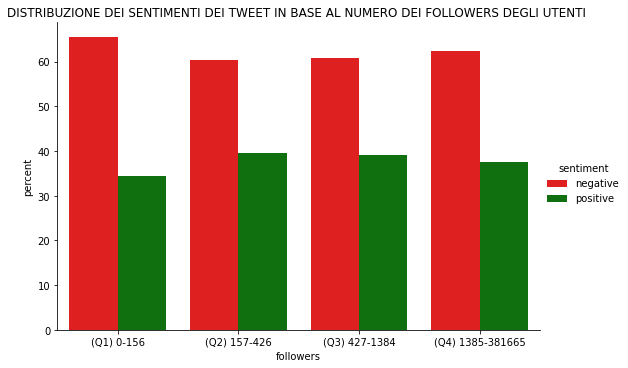

In [ ]:
sns.catplot(data=df1,x='followers',y='percent',hue='sentiment',palette=['r','g'],kind="bar",aspect=1.5)
plt.title('DISTRIBUZIONE DEI SENTIMENTI DEI TWEET IN BASE AL NUMERO DEI FOLLOWERS DEGLI UTENTI ') 

print()

In [ ]:
#df.loc[(df['followers']=='(Q1) 0-156')].count()#=1612
#df.loc[(df['followers']=='(Q1) 0-156') & (df['emotion']=='sadness')].count()#=242
#df.loc[(df['followers']=='(Q1) 0-156') & (df['emotion']=='fear')].count()#=164
#df.loc[(df['followers']=='(Q1) 0-156') & (df['emotion']=='anger')].count()#=583
#df.loc[(df['followers']=='(Q1) 0-156') & (df['emotion']=='joy')].count()#=623
#df.loc[(df['followers']=='(Q2) 157-426')].count()#=1629
#df.loc[(df['followers']=='(Q2) 157-426') & (df['emotion']=='sadness')].count()#=249
#df.loc[(df['followers']=='(Q2) 157-426') & (df['emotion']=='fear')].count()#=230
#df.loc[(df['followers']=='(Q2) 157-426') & (df['emotion']=='anger')].count()#=424
#df.loc[(df['followers']=='(Q2) 157-426') & (df['emotion']=='joy')].count()#=726
#df.loc[(df['followers']=='(Q3) 427-1384')].count()#=1601
#df.loc[(df['followers']=='(Q3) 427-1384') & (df['emotion']=='sadness')].count()#=247
#df.loc[(df['followers']=='(Q3) 427-1384') & (df['emotion']=='fear')].count()#=193
#df.loc[(df['followers']=='(Q3) 427-1384') & (df['emotion']=='anger')].count()#=450
#df.loc[(df['followers']=='(Q3) 427-1384') & (df['emotion']=='joy')].count()#=711
#df.loc[(df['followers']=='(Q4) 1385-381665')].count()#=1601
#df.loc[(df['followers']=='(Q4) 1385-381665') & (df['emotion']=='sadness')].count()#=266
#df.loc[(df['followers']=='(Q4) 1385-381665') & (df['emotion']=='fear')].count()#=182
#df.loc[(df['followers']=='(Q4) 1385-381665') & (df['emotion']=='anger')].count()#=464
#df.loc[(df['followers']=='(Q4) 1385-381665') & (df['emotion']=='joy')].count()#=689

In [ ]:
z={'percent':[(242/1612)*100,(164/1612)*100,(583/1612)*100,(623/1612)*100,(249/1629)*100,(230/1629)*100,(424/1629)*100,(726/1629)*100,(247/1601)*100,(193/1601)*100,(450/1601)*100,(711/1601)*100,(266/1601)*100,(182/1601)*100,(464/1601)*100,(689/1601)*100],'emotion':['sadness','fear','anger','joy','sadness','fear','anger','joy','sadness','fear','anger','joy','sadness','fear','anger','joy'],'followers':['(Q1) 0-156','(Q1) 0-156','(Q1) 0-156','(Q1) 0-156','(Q2) 157-426','(Q2) 157-426','(Q2) 157-426','(Q2) 157-426','(Q3) 427-1384','(Q3) 427-1384','(Q3) 427-1384','(Q3) 427-1384','(Q4) 1385-381665','(Q4) 1385-381665','(Q4) 1385-381665','(Q4) 1385-381665']}
df1=pd.DataFrame(data=z)


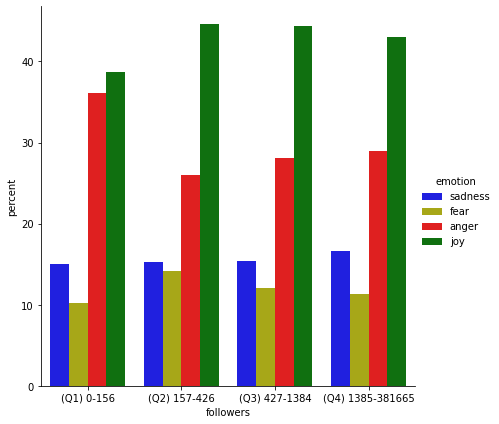

In [ ]:
sns.catplot(data=df1,x='followers',y='percent',hue='emotion',kind='bar', dodge=True,palette=["b","y","r","g"],height=6)
plt.title('') 
print()

In [ ]:
decili=pd.DataFrame(datasent['follower_count'].quantile(np.linspace(0.0,1.0,num=10)))
decili


,follower_count
0.000000,0.000000
0.111111,37.000000
0.222222,122.000000
0.333333,258.666667
0.444444,413.000000
0.555556,547.000000
0.666667,868.000000
0.777778,1537.000000
0.888889,3059.000000
1.000000,381665.000000


In [ ]:
data=datasent
d1=data.loc[data['follower_count']<=37]
d1['followers']='(P1) 0-37'
d2=data.loc[(data['follower_count']>37)&(data['follower_count']<=122)]
d2['followers']='(P2) 38-122'
d3=data.loc[(data['follower_count']>122)&(data['follower_count']<=259)]
d3['followers']='(P3) 123-259'
d4=data.loc[(data['follower_count']>259)&(data['follower_count']<=413)]
d4['followers']='(P4) 260-413'
d5=data.loc[(data['follower_count']>413)&(data['follower_count']<=547)]
d5['followers']='(P5) 414-547'
d6=data.loc[(data['follower_count']>547)&(data['follower_count']<=868)]
d6['followers']='(P6) 548-868'
d7=data.loc[(data['follower_count']>868)&(data['follower_count']<=1537)]
d7['followers']='(P7) 869-1537'
d8=data.loc[(data['follower_count']>1537)&(data['follower_count']<=3059)]
d8['followers']='(P8) 1538-3059'
d9=data.loc[(data['follower_count']>3059)&(data['follower_count']<=381665)]
d9['followers']='(P9) 3060-381665'
df=pd.concat([d1,d2,d3,d4,d5,d6,d7,d8,d9])
df


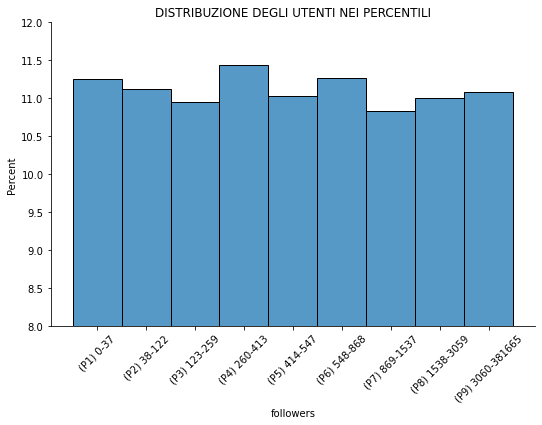

In [ ]:
sns.displot(df,x='followers',kind='hist',aspect=1.5,stat="percent",)
plt.title("DISTRIBUZIONE DEGLI UTENTI NEI PERCENTILI")
plt.ylim(8,12)
plt.xticks(rotation=45)
print()

In [ ]:
#df.loc[(df['followers']=='(P1) 0-37')].count()#=725
#df.loc[(df['followers']=='(P1) 0-37') & (df['sentiment']=='negative')].count()#=512
#df.loc[(df['followers']=='(P1) 0-37') & (df['sentiment']=='positive')].count()#=213
#df.loc[(df['followers']=='(P2) 38-122')].count()#=717
#df.loc[(df['followers']=='(P2) 38-122') & (df['sentiment']=='negative')].count()#=450
#df.loc[(df['followers']=='(P2) 38-122') & (df['sentiment']=='positive')].count()#=267
#df.loc[(df['followers']=='(P3) 123-259')].count()#=706
#df.loc[(df['followers']=='(P3) 123-259') & (df['sentiment']=='negative')].count()#=434
#df.loc[(df['followers']=='(P3) 123-259') & (df['sentiment']=='positive')].count()#=272
#df.loc[(df['followers']=='(P4) 260-413')].count()#=737
#df.loc[(df['followers']=='(P4) 260-413') & (df['sentiment']=='negative')].count()#=434
#df.loc[(df['followers']=='(P4) 260-413') & (df['sentiment']=='positive')].count()#=303
#df.loc[(df['followers']=='(P5) 414-547')].count()#=711
#df.loc[(df['followers']=='(P5) 414-547') & (df['sentiment']=='negative')].count()#=416
#df.loc[(df['followers']=='(P5) 414-547') & (df['sentiment']=='positive')].count()#=295
#df.loc[(df['followers']=='(P6) 548-868')].count()#=726
#df.loc[(df['followers']=='(P6) 548-868') & (df['sentiment']=='negative')].count()#=468
#df.loc[(df['followers']=='(P6) 548-868') & (df['sentiment']=='positive')].count()#=258
#df.loc[(df['followers']=='(P7) 869-1537')].count()#=698
#df.loc[(df['followers']=='(P7) 869-1537') & (df['sentiment']=='negative')].count()#=410
#df.loc[(df['followers']=='(P7) 869-1537') & (df['sentiment']=='positive')].count()#=288
#df.loc[(df['followers']=='(P8) 1538-3059')].count()#=709
#df.loc[(df['followers']=='(P8) 1538-3059') & (df['sentiment']=='negative')].count()#=447
#df.loc[(df['followers']=='(P8) 1538-3059') & (df['sentiment']=='positive')].count()#=262
#df.loc[(df['followers']=='(P9) 3060-381665')].count()#=714
#df.loc[(df['followers']=='(P9) 3060-381665') & (df['sentiment']=='negative')].count()#=443
#df.loc[(df['followers']=='(P9) 3060-381665') & (df['sentiment']=='positive')].count()#=271







In [ ]:
z={'percent':[(512/725)*100,(213/725)*100,(450/717)*100,(267/717)*100,(434/706)*100,(272/706)*100,(434/737)*100,(303/737)*100,(416/711)*100,(295/711)*100,(468/726)*100,(258/726)*100,(410/698)*100,(288/698)*100,(447/709)*100,(262/709)*100,(443/714)*100,(271/714)*100],'sentiment':['negative','positive','negative','positive','negative','positive','negative','positive','negative','positive','negative','positive','negative','positive','negative','positive','negative','positive'],'followers':['(P1) 0-37','(P1) 0-37','(P2) 38-122','(P2) 38-122','(P3) 123-259','(P3) 123-259','(P4) 260-413','(P4) 260-413','(P5) 414-547','(P5) 414-547','(P6) 548-868','(P6) 548-868','(P7) 869-1537','(P7) 869-1537','(P8) 1538-3059','(P8) 1538-3059','(P9) 3060-381665','(P9) 3060-381665']}
df1=pd.DataFrame(data=z)






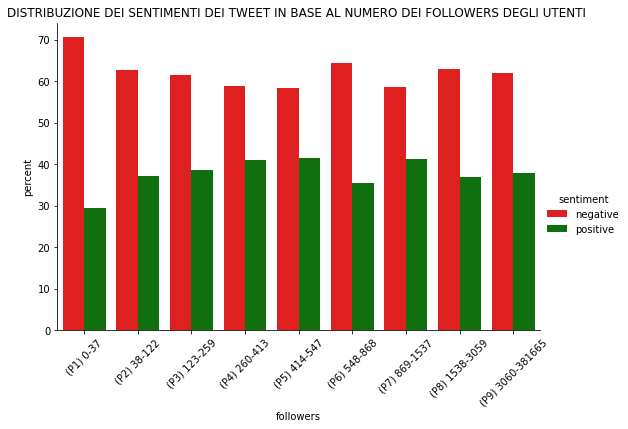

In [ ]:
sns.catplot(data=df1,x='followers',y='percent',hue='sentiment',palette=['r','g'],kind="bar",aspect=1.5)
plt.title('DISTRIBUZIONE DEI SENTIMENTI DEI TWEET IN BASE AL NUMERO DEI FOLLOWERS DEGLI UTENTI ') 
plt.xticks(rotation=45)
print()

In [ ]:
dfp1=df.loc[df['followers']=='(P1) 0-37']
dfp2p9=df.loc[df['followers']!='(P1) 0-37']
# da approfondire il motivo della differenza

In [ ]:
words=pd.Series(dfp1['cleaned_text']).astype('string').str.cat(sep=' ')

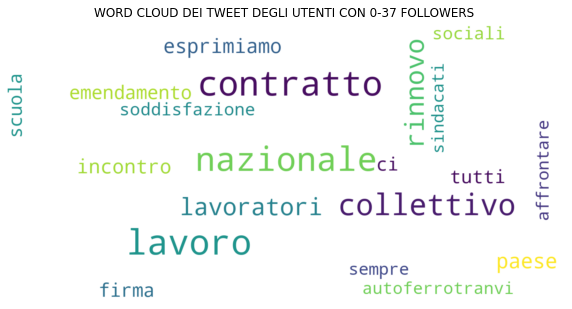

In [ ]:
wordcloud = WordCloud(width=1600, stopwords=stopwords,height=800,max_font_size=100,max_words=20,collocations=False, background_color='white').generate(words)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('WORD CLOUD DEI TWEET DEGLI UTENTI CON 0-37 FOLLOWERS ')
print()   

In [ ]:
words1=pd.Series(dfp2p9['cleaned_text']).astype('string').str.cat(sep=' ')

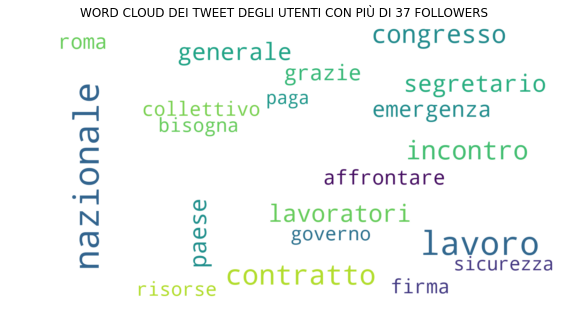

In [ ]:
wordcloud = WordCloud(width=1600, stopwords=stopwords,height=800,max_font_size=100,max_words=20,collocations=False, background_color='white').generate(words1)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('WORD CLOUD DEI TWEET DEGLI UTENTI CON PIÙ DI 37 FOLLOWERS ')
print() 